In [1]:
from pathlib import Path
import czifile
import napari
import numpy as np
import skimage
from skimage import measure, exposure
from skimage.measure import regionprops_table
import pandas as pd
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
# import gc

# Select a GPU with the following in the name. This will fallback to any other GPU if none with this name is found
cle.select_device("RTX")

c:\Users\albertds\mambaforge\envs\microglia\lib\site-packages\pyclesperanto_prototype\_tier0\_device.py:77: UserWarning: No OpenCL device found with RTX in their name. Using Intel(R) UHD Graphics 630 instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


<Intel(R) UHD Graphics 630 on Platform: Intel(R) OpenCL HD Graphics (1 refs)>

In [2]:
directory_path = Path("./raw_data/")
images = []

# Iterate through the lsm files in the directory
for file_path in directory_path.glob("*.czi"):
    images.append(str(file_path))
    
images

['raw_data\\well 1.czi',
 'raw_data\\well 10.czi',
 'raw_data\\well 11.czi',
 'raw_data\\well 12.czi',
 'raw_data\\well 13.czi',
 'raw_data\\well 14.czi',
 'raw_data\\well 15.czi',
 'raw_data\\well 2.czi',
 'raw_data\\well 3.czi',
 'raw_data\\well 4.czi',
 'raw_data\\well 5.czi',
 'raw_data\\well 6.czi',
 'raw_data\\well 7.czi',
 'raw_data\\well 8.czi',
 'raw_data\\well 9.czi']

In [3]:
image = images[0]

# Extract filename and well_id
file_path = Path(image)
filename = file_path.stem
well_id = filename.split(" ")[1]

# Read the image file and remove singleton dimensions
img = czifile.imread(image)
img = img.squeeze()

# Image size reduction to improve processing times (slicing, not lossless compression)
slicing_factor = 4 # Use 2 or 4 for compression (None for lossless)

# Extract the stack containing the nuclei (0), dna_damage (1) and microglia channel (2)
ki67_stack = img[0, :, ::slicing_factor, ::slicing_factor]
nuclei_stack = img[2, :, ::slicing_factor, ::slicing_factor]
caspase_stack = img[3, :, ::slicing_factor, ::slicing_factor]

# Perform maximum intensity projections
ki67_mip = np.max(ki67_stack, axis = 0)
nuclei_mip = np.max(nuclei_stack, axis = 0)
caspase_mip = np.max(caspase_stack, axis = 0)

# Free up memory by deleting the img variable
del img
# Call the garbage collector
# gc.collect()

In [4]:
#TODO: Make 3D stack isotropic

# Voxel size from .czi file metadata
input_image = nuclei_stack

voxel_size_x = 0.21
voxel_size_y = 0.21
voxel_size_z = 2.17

# Adjust so voxel size_x and size_y so they are equal to 1 to avoid compression upon rescaling

multiplier = 0.5 / voxel_size_x

voxel_size_x = voxel_size_x * multiplier
voxel_size_y = voxel_size_y * multiplier
voxel_size_z = voxel_size_z * multiplier

print(voxel_size_x, voxel_size_y, voxel_size_z)

0.5 0.5 5.166666666666666


In [5]:
resampled = cle.scale(input_image, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, auto_size=True)
background_subtracted = cle.top_hat_box(resampled, radius_x=5, radius_y=5, radius_z=5)
segmented = cle.voronoi_otsu_labeling(background_subtracted, spot_sigma=1, outline_sigma=1)
resampled_ki67 = cle.scale(ki67_stack, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, auto_size=True)


In [6]:
nuclei_labels_3d = cle.pull(segmented)
resampled_ki67 = cle.pull(resampled_ki67)

# Extract regionprops
props = regionprops_table(label_image=nuclei_labels_3d, intensity_image=resampled_ki67, properties=["label", "intensity_mean", "intensity_max", "centroid", "area_filled"])

# Construct a dataframe
df = pd.DataFrame(props)

df

,label,intensity_mean,intensity_max,centroid-0,centroid-1,centroid-2,area_filled
0,1,43.373058,160.0,17.735751,7.170984,1.077720,193.0
1,2,4.534654,14.0,35.722772,12.623762,0.554455,101.0
2,3,5.379310,14.0,48.183908,17.632184,0.827586,87.0
3,4,16.657534,41.0,38.027397,31.698630,0.986301,73.0
4,5,10.569445,22.0,33.763889,33.069444,0.736111,72.0
...,...,...,...,...,...,...,...
17728,17729,58.610779,146.0,48.772455,447.017964,961.173653,167.0
17729,17730,15.034810,71.0,47.392405,452.686709,961.212025,316.0
17730,17731,27.000000,27.0,121.000000,469.000000,963.000000,1.0
17731,17732,50.569008,255.0,50.232446,470.915254,960.690073,413.0


In [7]:
labels_to_filter = [13731, 14156, 13134, 14384, 14468, 14386, 14406]

filtered_df = df[df['label'].isin(labels_to_filter)]

filtered_df

,label,intensity_mean,intensity_max,centroid-0,centroid-1,centroid-2,area_filled
13133,13134,105.701378,255.0,33.316998,443.588055,641.754977,653.0
13730,13731,103.920341,255.0,30.861017,374.584746,676.300000,590.0
14155,14156,103.858292,255.0,33.594203,380.294686,699.547504,621.0
14383,14384,42.863407,226.0,32.791980,382.895990,710.442356,798.0
14385,14386,4.079890,16.0,34.644628,420.099174,712.151515,363.0
14405,14406,8.067164,33.0,33.690299,492.000000,712.802239,268.0
14467,14468,39.250000,217.0,35.460526,386.996711,716.115132,304.0


In [8]:
viewer = napari.Viewer(ndisplay=2)
viewer.add_image(resampled)
viewer.add_image(resampled_ki67)
viewer.add_labels(nuclei_labels_3d)


<Image layer 'resampled_ki67' at 0x14335dd24c0>

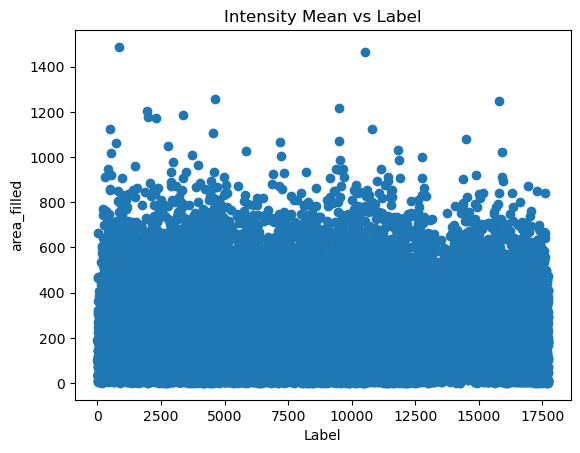

In [9]:
plt.scatter(df['label'], df['area_filled'])
plt.title('Intensity Mean vs Label')
plt.xlabel('Label')
plt.ylabel('area_filled')
plt.show()